# **Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"**

Nhóm 3:
1. 1712401 - Hồ Trường Giang - TruongGiangBT
2. 1712575 - Hoàng Xuân Long - dralong10
3. 18120249 - Hồ Minh Trí - Crys-Zz0o0
4. 18120374 - Nguyễn Minh Hiếu - templarassVN

Link thùng chứa Github của nhóm: [Link](https://github.com/templarassVN/Team-3_KHDLUD_K18)

## Mô tả bài toán

- Là cuộc thi dự đoán đội thắng và đội thua trong giải đấu bóng rổ nam NCAA năm 2021 (2020-2021) (2021 NCAA Division I Men's Basketball Tournament). [Link](https://www.kaggle.com/c/ncaam-march-mania-2021)
- Cuộc thi chia làm 2 giai đoạn:
  + Giai đoạn 1: Ban tổ chức sẽ cung cấp dữ liệu các trận đấu của các đội ở các mùa giải trước đến mùa giải 2019. Mục đích là để người tham gia có dữ liệu để xây dựng và thử nghiệm các mô hình.
  + Giai đoạn 2: Ban tổ chức sẽ cung cấp thêm dữ liệu về các đội được tham gia giải đấu năm 2021. Người tham gia sẽ tiến hành dự đoán và submit kết quả.
- Tổng quan về giải đấu:
  + Giải đấu gồm 68 đội tham gia chia đều ở 4 khu vực.
  + 8 đội First-Four sẽ thi đấu 4 trận đấu đầu tiên để tranh quyền đi tiếp => Còn lại 64 đội (Mỗi khu cực có 16 đội).
  + 16 đội trong mỗi khu vực sẽ đấu loại trực tiếp theo quy định của giải đấu và chọn ra đội thắng cuộc đại diện cho khu vực thi đấu ở vòng Final Four. Tại vòng Final Four, 4 đội đại diện cho 4 khu vực tiếp tục loại trực tiếp nhau và chọn ra người thắng chung cuộc. 
  + Tổng cộng sẽ có 67 trận đấu (gồm 4 trận First-Four, 15 trận đấu loại khu vực * 4 khu vực, 3 trận Final Four).
- Mô hình bài toán: Dựa vào các thông số thi đấu và thành tích. Ta sẽ thực hiện huấn luyện mô hình với input đầu vào là ID 2 đội (TeamIdA,TeamIdB) và các thuộc tính được rút trích của mỗi đội. Nhãn của mỗi cặp đấu có giá trị là 0 hoặc 1 (0 - đội A thua; 1 - đội A thắng)
- Input bài toán: Đầu vào bài toán là danh sách 68 đội tham gia giải đấu, về mặt lý thuyết ta sẽ có 68*67/2 = 2278 cặp đấu khác nhau. Ta sẽ dự đoán kết quả của 2278 cặp đấu.
- Output: Xác suất đội A thắng đội B.
- Cấu trúc file Submission gồm:
  + Id: [Mùa giải]_ [TeamIdA]_[TeamIdB]. Ex: 2021_1101_1102
  + Pred: Xác suất đội A thắng đội B
- Đánh giá kết quả: Kết quả dự đoán được đánh giá bằng hàm Log Loss.
$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$

## Giải quyết bài toán

- Nhóm đã tìm hiểu và cài đặt lại [giải pháp của tác giả kazukim](https://www.kaggle.com/c/ncaam-march-mania-2021/discussion/230946), đứng thứ 4 private leaderboard với score là 0.56346.

### .Nạp dữ liệu và thư viện cần thiết

In [ ]:
!gdown --id 1c6Iiy39qeiI1sH1N5MKrBe1C9e8E16Hl
!gdown --id 1Bwe5QinxXItR6g5ODd8AGFYeHQR1xNJ-
!unzip ncaam-march-mania-2021.zip

Downloading...
From: https://drive.google.com/uc?id=1c6Iiy39qeiI1sH1N5MKrBe1C9e8E16Hl
To: /content/ncaam-march-mania-2021.zip
100% 44.7M/44.7M [00:00<00:00, 62.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Bwe5QinxXItR6g5ODd8AGFYeHQR1xNJ-
To: /content/2021NCAA.csv
100% 895/895 [00:00<00:00, 651kB/s]
Archive:  ncaam-march-mania-2021.zip
replace MDataFiles_Stage1/Cities.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import lightgbm as lgb

### I. Cấu hình

In [ ]:
# Cấu hình các tham số của Model
SEED = 1010
LGBM_PARAMS = {
    'num_leaves': 300, # Số lá tối đa
    'max_bin':450, #Số bin tối đa
    'objective': 'binary', # Loại mô hình (binary: hồi quy logistic)
    'learning_rate': 0.01, # Tỉ lệ học
    'boosting_type': 'gbdt',  
    'random_state': 1010, # Tạo seed random
    'metric':"binary_logloss",
    'verbosity':-1
}
LGBM_FIT_PARAMS = {
    'num_boost_round': 10000, # Số vòng thực hiện tăng cường
    'early_stopping_rounds': 50, # Số lần mà nếu valid_score ngưng cải thiện thì sẽ dừng sớm 
    'verbose_eval': 100, # In ra đánh giá sau verbose_eval lần
}

#### 1. Hàm hàm huấn luyện LightGBM

In [ ]:

def train_lgbm(X_train, Y_train, X_valid, Y_valid, X_test, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):

    train = lgb.Dataset(X_train, Y_train,)

    if X_valid is not None: 
        valid = lgb.Dataset(X_valid, Y_valid)
        model = lgb.train(lgb_params, train,
                          valid_sets=[train,valid], **fit_params)
        Y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(Y_valid, Y_pred_valid)
    else:
        model = lgb.train(lgb_params, train,
                          **fit_params)
        Y_pred_valid = None
        valid_loss = None

    if X_test is not None:
        Y_pred_test = model.predict(X_test) 
    else:
        Y_pred_test = None

    if calc_importances:
        importances = pd.DataFrame()
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return Y_pred_valid, Y_pred_test, valid_loss, importances, model.best_iteration, model

#### 2. Hàm thiết lập đầu vào

In [ ]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "Score1", 
        "LTeamID" : "TeamIdB",
        "LScore": "Score2",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FG%W':'FG%A',
        '3P%W':'3P%A',
        'FT%W':'FT%A',
        'eFG%W':'eFG%A',
        'TOV%W':'TOV%A',
        'FreeThrowsW':'FreeThrowsA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'TS%W':'TS%A',
        'EVW':'EVA',
        'TRW':'TRA',
        'OR%W':'OR%A',
        'ScoreW':'ScoreA',
        'ScoredW':'ScoredA',
        'ScoregapW':'ScoregapA',
        'NumWinsW': 'NumWinsA', 
        'NumLosesW':'NumLosesA', 
        'WinRatioW':'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FG%L':'FG%B',
        '3P%L':'3P%B',
        'FT%L':'FT%B',
        'eFG%L':'eFG%B',
        'TOV%L':'TOV%B',
        'FreeThrowsL':'FreeThrowsB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'TS%L':'TS%B',
        'EVL':'EVB',
        'TRL':'TRB',
        'OR%L':'OR%B',
        'ScoreL':'ScoreB',
        'ScoredL':'ScoredB',
        'ScoregapL':'ScoregapB',
        'NumWinsL': 'NumWinsB',
        'NumLosesL':'NumLosesB', 
        'WinRatioL':'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "Score2", 
        "LTeamID" : "TeamIdA",
        "LScore": "Score1",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FG%W':'FG%B',
        '3P%W':'3P%B',
        'FT%W':'FT%B',
        'eFG%W':'eFG%B',
        'TOV%W':'TOV%B',
        'FreeThrowsW':'FreeThrowsB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'TS%W':'TS%B',
        'EVW':'EVB',
        'TRW':'TRB',
        'OR%W':'OR%B',
        'ScoreW':'ScoreB',
        'ScoredW':'ScoredB',
        'ScoregapW':'ScoregapB',
        'NumWinsW': 'NumWinsB', 
        'NumLosesW':'NumLosesB', 
        'WinRatioW':'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FG%L':'FG%A',
        '3P%L':'3P%A',
        'FT%L':'FT%A',
        'eFG%L':'eFG%A',
        'TOV%L':'TOV%A',
        'FreeThrowsL':'FreeThrowsA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'TS%L':'TS%A',
        'EVL':'EVA',
        'TRL':'TRA',
        'OR%L':'OR%A',
        'ScoreL':'ScoreA',
        'ScoredL':'ScoredA',
        'ScoregapL':'ScoregapA',
        'NumWinsL': 'NumWinsA',
        'NumLosesL':'NumLosesA', 
        'WinRatioL':'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

### II. Đọc dữ liệu

In [ ]:
datasets_path = './MDataFiles_Stage2/'
os.listdir('./MDataFiles_Stage2/')

['MGameCities.csv',
 'MConferenceTourneyGames.csv',
 'MTeams.csv',
 'MTeamSpellings.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MSeasons.csv',
 'MSampleSubmissionStage2.csv',
 'MNCAATourneyCompactResults.csv',
 'MMasseyOrdinals.csv',
 'MRegularSeasonCompactResults.csv',
 'MNCAATourneySlots.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MNCAATourneySeeds.csv',
 'MTeamConferences.csv',
 'Cities.csv',
 'MTeamCoaches.csv',
 'MSecondaryTourneyTeams.csv',
 'Conferences.csv',
 'MNCAATourneyDetailedResults.csv',
 'MRegularSeasonDetailedResults.csv']

In [ ]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RankingDayNum':'DayNum'})
seeds = pd.read_csv(datasets_path + 'MNCAATourneySeeds.csv')
regular_results = pd.read_csv(datasets_path + 'MRegularSeasonDetailedResults.csv')
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')

### III. Prerocessing, Feature Extraction

#### 1. Tính trung bình tất cả hệ thống Rank and chuyển đổi sang Rating

In [ ]:
# Lấy thứ hạn cuối cùng (thường DayNum=133) theo nhóm
ordinals = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()
# Tạo bảng gồm Season, TeamID, OrdinalRank; với OrdinalRank là thứ hạn trung bình trên các SystemName
ordinals = ordinals.groupby(['Season','TeamID'])['OrdinalRank'].apply(list).apply(np.mean).reset_index()
# Thêm thuộc tính Rating = 100 - 4*log(OrdinalRank +1) - OrdinalRank/22
ordinals['Rating'] = 100-4*np.log(ordinals['OrdinalRank']+1)-ordinals['OrdinalRank']/22
ordinals

Season  TeamID  OrdinalRank     Rating
0       2003    1102   154.058824  72.822108
1       2003    1103   168.705882  71.795283
2       2003    1104    36.638889  83.822445
3       2003    1105   308.735294  63.023705
4       2003    1106   260.911765  65.868344
...      ...     ...          ...        ...
6539    2021    1467   240.490566  67.121289
6540    2021    1468   180.288462  71.004712
6541    2021    1469   314.666667  62.678222
6542    2021    1470   252.823529  66.361464
6543    2021    1471   254.384615  66.265980

[6544 rows x 4 columns]

#### 2. Tính số trận thắng/thua của đội trong mùa giải

In [ ]:
# Đếm số tận thắng
num_win = regular_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
# Đếm số trận thua
num_lose = regular_results.groupby(['Season', 'LTeamID']).count()
num_lose = num_lose.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLoses", "LTeamID": "TeamID"})
# Ghép 2 bảng lại
win_lose = pd.merge(num_win, num_lose, how='outer', on=['Season', 'TeamID']).fillna(0).sort_values(by=['Season','TeamID']).reset_index(drop=True)
win_lose

Season  TeamID  NumWins  NumLoses
0       2003    1102     12.0      16.0
1       2003    1103     13.0      14.0
2       2003    1104     17.0      11.0
3       2003    1105      7.0      19.0
4       2003    1106     13.0      15.0
...      ...     ...      ...       ...
6529    2021    1467      9.0       9.0
6530    2021    1468     11.0       7.0
6531    2021    1469      6.0      13.0
6532    2021    1470      5.0      10.0
6533    2021    1471      4.0      10.0

[6534 rows x 4 columns]

#### 3. Thống kê trung bình số liệu của đội trong mỗi mùa giải

In [ ]:
# Tính trung bình số liệu trận thắng của mỗi đội theo mùa
wteam_stats = regular_results.groupby(['Season', 'WTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thua
wteam_stats = wteam_stats.drop(['DayNum','LTeamID', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 
                                'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',], axis=1)
# Đổi tên các thuộc tính của đội thắng thành tên chung
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score','LScore':'Scored', 'WFGM':'FGM',
                                        'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA',
                                        'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

Season  TeamID      Score  ...        Stl       Blk         PF
0       2003    1102  68.750000  ...   7.333333  2.833333  16.083333
1       2003    1103  87.769231  ...   7.307692  1.846154  20.461538
2       2003    1104  74.705882  ...   7.235294  4.176471  16.470588
3       2003    1105  79.428571  ...  11.285714  2.000000  19.428571
4       2003    1106  68.307692  ...   9.384615  3.769231  18.384615
...      ...     ...        ...  ...        ...       ...        ...
6523    2021    1467  71.000000  ...   8.222222  3.888889   3.555556
6524    2021    1468  76.000000  ...   7.181818  2.272727   1.636364
6525    2021    1469  76.666667  ...   7.333333  1.666667   3.333333
6526    2021    1470  69.000000  ...   6.200000  2.000000  15.000000
6527    2021    1471  86.500000  ...   8.250000  2.000000  11.250000

[6528 rows x 17 columns]

In [ ]:
# Tính trung bình số liệu trận thua của mỗi đội theo mùa
lteam_stats = regular_results.groupby(['Season', 'LTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thắng
lteam_stats = lteam_stats.drop(['DayNum', 'WTeamID', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM',
                                'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1)
# Đổi tên các thuộc tính của đội thua thành tên chung
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score','WScore':'Scored', 'LFGM':'FGM',
                                        'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA',
                                        'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

Season  TeamID     Scored  ...       Stl       Blk         PF
0       2003    1102  59.875000  ...  4.937500  1.000000  20.750000
1       2003    1103  77.928571  ...  7.214286  2.785714  19.285714
2       2003    1104  70.363636  ...  5.636364  3.181818  20.454545
3       2003    1105  80.421053  ...  8.578947  2.105263  20.526316
4       2003    1106  68.800000  ...  7.466667  2.600000  18.000000
...      ...     ...        ...  ...       ...       ...        ...
6526    2021    1467  71.555556  ...  7.777778  3.666667  11.777778
6527    2021    1468  77.571429  ...  5.714286  1.714286   4.285714
6528    2021    1469  81.153846  ...  6.461538  2.230769   4.769231
6529    2021    1470  74.100000  ...  7.000000  2.400000   2.600000
6530    2021    1471  75.800000  ...  4.700000  1.600000   4.200000

[6531 rows x 17 columns]

In [ ]:
# Ghép 2 số liệu của các trận thắng và thua lại
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
# Tính trung bình
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()
regular_season_feature

Season  TeamID      Score  ...       Stl       Blk         PF
0       2003    1102  58.687500  ...  6.135417  1.916667  18.416667
1       2003    1103  79.098901  ...  7.260989  2.315934  19.873626
2       2003    1104  67.807487  ...  6.435829  3.679144  18.462567
3       2003    1105  74.187970  ...  9.932331  2.052632  19.977444
4       2003    1106  63.920513  ...  8.425641  3.184615  18.192308
...      ...     ...        ...  ...       ...       ...        ...
6529    2021    1467  66.277778  ...  8.000000  3.777778   7.666667
6530    2021    1468  71.571429  ...  6.448052  1.993506   2.961039
6531    2021    1469  70.064103  ...  6.897436  1.948718   4.051282
6532    2021    1470  65.150000  ...  6.600000  2.200000   8.800000
6533    2021    1471  74.000000  ...  6.475000  1.800000   7.725000

[6534 rows x 17 columns]

#### 4. Tính và thêm các thuộc tính Scoregap, FG%, 3P%, FT%, EV, TR, TS, eFG%, OR%, TOV%, FreeThrows, POSS, PPP

In [ ]:
# Score-gab: Độ chênh lệch điểm ???
regular_season_feature['Scoregap'] = regular_season_feature['Score'] - regular_season_feature['Scored']
# FG%: Hiệu suất ghi bàn
regular_season_feature['FG%'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# 3P%: Hiệu suất cú ném 3 điểm
regular_season_feature['3P%'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FT% (Free Throws Percentage): Hiệu suất cú ném tự do
regular_season_feature['FT%'] = regular_season_feature['FTM']/regular_season_feature['FTA']
# EV(expect value) ???
regular_season_feature['EV'] = regular_season_feature['FGM']*regular_season_feature['FG%'] \
                            + regular_season_feature['FGM3']*regular_season_feature['3P%'] \
                            + regular_season_feature['FTM']*regular_season_feature['FT%'] \
# TR (Total Rebounds)
regular_season_feature['TR'] = regular_season_feature['OR'] + regular_season_feature['DR']
# TS% (True Shooting Percentage)
regular_season_feature['TS%'] = regular_season_feature['Score']/(2*(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA']))
## Four-Factor
# eFG% (Effective Field Goal Percentage)
regular_season_feature['eFG%'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']
# OR% (Offensive Rebound) ???
regular_season_feature['OR%'] = regular_season_feature['OR']/regular_season_feature['FGA']
# TOV% (Turnovers)
regular_season_feature['TOV%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])
# 
regular_season_feature['FreeThrows'] = regular_season_feature['FTM']/regular_season_feature['FGA']

# PPP/POSS ???
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] + regular_season_feature['TO']

regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Lose
regular_season_feature = regular_season_feature.merge(win_lose, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins'] + regular_season_feature['NumLoses'])

regular_season_feature

Season  TeamID      Score  ...  NumWins  NumLoses  WinRatio
0       2003    1102  58.687500  ...     12.0      16.0  0.428571
1       2003    1103  79.098901  ...     13.0      14.0  0.481481
2       2003    1104  67.807487  ...     17.0      11.0  0.607143
3       2003    1105  74.187970  ...      7.0      19.0  0.269231
4       2003    1106  63.920513  ...     13.0      15.0  0.464286
...      ...     ...        ...  ...      ...       ...       ...
6529    2021    1467  66.277778  ...      9.0       9.0  0.500000
6530    2021    1468  71.571429  ...     11.0       7.0  0.611111
6531    2021    1469  70.064103  ...      6.0      13.0  0.315789
6532    2021    1470  65.150000  ...      5.0      10.0  0.333333
6533    2021    1471  74.000000  ...      4.0      10.0  0.285714

[6534 rows x 33 columns]

#### 5. Ghép các bảng lại

In [ ]:
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
# Lấy thông tin mùa giải 2003 đến nay
tourney_results = tourney_results[tourney_results['Season'] >= 2003].reset_index(drop=True)
# Ghép mã các đội thắng với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={ 'NumWins': 'NumWinsW', 'NumLoses':'NumLosesW', 'WinRatio': 'WinRatioW',
                                                 'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW',
                                                 'OR':'ORW','DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
                                                 'FG%':'FG%W','3P%':'3P%W','FT%':'FT%W','eFG%':'eFG%W','TOV%':'TOV%W',
                                                 'FreeThrows':'FreeThrowsW', 'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W',
                                                 'Score':'ScoreW', 'Scored':'ScoredW','Scoregap':'ScoregapW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thắng với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={'NumWins': 'NumWinsL', 'NumLoses':'NumLosesL', 'WinRatio': 'WinRatioL',
                                                'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
                                                'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
                                                'FG%':'FG%L','3P%':'3P%L','FT%':'FT%L','eFG%':'eFG%L','TOV%':'TOV%L','FreeThrows':'FreeThrowsL',
                                                'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
                                                'Scored':'ScoredL','Scoregap':'ScoregapL'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingL'}).drop(columns='TeamID', axis=1)
tourney_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'ScoreW', 'ScoredW', 'FGMW', 'FGAW', 'FGM3W', 'FGA3W', 'FTMW',
       'FTAW', 'ORW', 'DRW', 'AstW', 'TOW', 'StlW', 'BlkW', 'PFW', 'ScoregapW',
       'FG%W', '3P%W', 'FT%W', 'EVW', 'TRW', 'TS%W', 'eFG%W', 'OR%W', 'TOV%W',
       'FreeThrowsW', 'POSSW', 'PPPW', 'NumWinsW', 'NumLosesW', 'WinRatioW',
       'RatingW', 'ScoreL', 'ScoredL', 'FGML', 'FGAL', 'FGM3L', 'FGA3L',
       'FTML', 'FTAL', 'ORL', 'DRL', 'AstL', 'TOL', 'StlL', 'BlkL', 'PFL',
       'ScoregapL', 'FG%L', '3P%L', 'FT%L', 'EVL', 'TRL', 'TS%L', 'eFG%L',
       'OR%L', 'TOV%L', 'FreeThrowsL', 'POSSL', 'PPPL', 'NumWinsL',
       'NumLosesL', 'WinRatioL', 'RatingL'],
      dtype='object')

#### 6. Bảng thống kê cuối cùng

In [ ]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['Score1'] - tourney_results['Score2']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

Season  DayNum  TeamIdA  Score1  ...  WinRatioB    RatingB ScoreDiff  WinA
0       2003     134     1421      92  ...   0.600000  67.244877         8     1
1       2003     136     1112      80  ...   0.655172  72.885042        29     1
2       2003     136     1113      84  ...   0.793103  86.125540        13     1
3       2003     136     1141      79  ...   0.878788  86.828207         6     1
4       2003     136     1143      76  ...   0.600000  81.985822         2     1
...      ...     ...      ...     ...  ...        ...        ...       ...   ...
1110    2019     146     1246      71  ...   0.735294  88.425452        -6     0
1111    2019     146     1181      67  ...   0.823529  92.515036        -1     0
1112    2019     152     1277      51  ...   0.812500  89.792819       -10     0
1113    2019     152     1120      62  ...   0.906250  95.757796        -1     0
1114    2019     154     1403      77  ...   0.906250  95.757796        -8     0

[2230 rows x 74 columns]

### IV. Test

In [ ]:
test = pd.read_csv(datasets_path + "MSampleSubmissionStage2.csv")
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

ID  Pred  Season  TeamIdA  TeamIdB
0  2021_1101_1104   0.5    2021     1101     1104
1  2021_1101_1111   0.5    2021     1101     1111
2  2021_1101_1116   0.5    2021     1101     1116
3  2021_1101_1124   0.5    2021     1101     1124
4  2021_1101_1140   0.5    2021     1101     1140

In [ ]:
test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsA', 'NumLoses':'NumLosesA', 'WinRatio': 'WinRatioA',
                'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
                'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
                'FG%':'FG%A','3P%':'3P%A','FT%':'FT%A','eFG%':'eFG%A','TOV%':'TOV%A','FreeThrows':'FreeThrowsA',
                'POSS':'POSSA','PPP':'PPPA','TS%':'TS%A','EV':'EVA','TR':'TRA','OR%':'OR%A','Score':'ScoreA',
                'Scored':'ScoredA','Scoregap':'ScoregapA'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingA'}).drop(columns='TeamID', axis=1)

test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsB', 'NumLoses':'NumLosesB', 'WinRatio': 'WinRatioB',
                'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
                'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
                'FG%':'FG%B','3P%':'3P%B','FT%':'FT%B','eFG%':'eFG%B','TOV%':'TOV%B','FreeThrows':'FreeThrowsB',
                'POSS':'POSSB','PPP':'PPPB','TS%':'TS%B','EV':'EVB','TR':'TRB','OR%':'OR%B','Score':'ScoreB',
                'Scored':'ScoredB','Scoregap':'ScoregapB'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingB'}).drop(columns='TeamID', axis=1)
test.columns

Index(['ID', 'Pred', 'Season', 'TeamIdA', 'TeamIdB', 'ScoreA', 'ScoredA',
       'FGMA', 'FGAA', 'FGM3A', 'FGA3A', 'FTMA', 'FTAA', 'ORA', 'DRA', 'AstA',
       'TOA', 'StlA', 'BlkA', 'PFA', 'ScoregapA', 'FG%A', '3P%A', 'FT%A',
       'EVA', 'TRA', 'TS%A', 'eFG%A', 'OR%A', 'TOV%A', 'FreeThrowsA', 'POSSA',
       'PPPA', 'NumWinsA', 'NumLosesA', 'WinRatioA', 'RatingA', 'ScoreB',
       'ScoredB', 'FGMB', 'FGAB', 'FGM3B', 'FGA3B', 'FTMB', 'FTAB', 'ORB',
       'DRB', 'AstB', 'TOB', 'StlB', 'BlkB', 'PFB', 'ScoregapB', 'FG%B',
       '3P%B', 'FT%B', 'EVB', 'TRB', 'TS%B', 'eFG%B', 'OR%B', 'TOV%B',
       'FreeThrowsB', 'POSSB', 'PPPB', 'NumWinsB', 'NumLosesB', 'WinRatioB',
       'RatingB'],
      dtype='object')

In [ ]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'Score1', 'TeamIdB', 'Score2', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']
features = [i for i in features if i not in drop_cols]
categorical_features = []
target = 'WinA'
features

['ScoreA',
 'ScoredA',
 'FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'ScoregapA',
 'FG%A',
 '3P%A',
 'FT%A',
 'EVA',
 'TRA',
 'TS%A',
 'eFG%A',
 'OR%A',
 'TOV%A',
 'FreeThrowsA',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLosesA',
 'WinRatioA',
 'RatingA',
 'ScoreB',
 'ScoredB',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'ScoregapB',
 'FG%B',
 '3P%B',
 'FT%B',
 'EVB',
 'TRB',
 'TS%B',
 'eFG%B',
 'OR%B',
 'TOV%B',
 'FreeThrowsB',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLosesB',
 'WinRatioB',
 'RatingB']

In [ ]:
seasons = tourney_results['Season'].unique()
n = 13 # season 2016

y_test = []
feature_importances = pd.DataFrame()
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=1010)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
        train_lgbm(
            x_train, y_train, x_val, y_val, test[features],
            fold_id = season,
            lgb_params = LGBM_PARAMS,
            fit_params = LGBM_FIT_PARAMS,
            loss_func = log_loss,
            calc_importances=True
        )
    models.append(model)
    y_test.append(y_pred_test)
    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

valid_season2016
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.411109	valid_1's binary_logloss: 0.56937
[200]	training's binary_logloss: 0.270784	valid_1's binary_logloss: 0.555731
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.298563	valid_1's binary_logloss: 0.553146
valid_season2017
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.414572	valid_1's binary_logloss: 0.584071
[200]	training's binary_logloss: 0.276617	valid_1's binary_logloss: 0.565678
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.317867	valid_1's binary_logloss: 0.564062
valid_season2018
Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.414891	valid_1's binary_logloss: 0.585661
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.38216	valid_1's binary_logloss: 0.582321
valid_season2019
Training until validation s

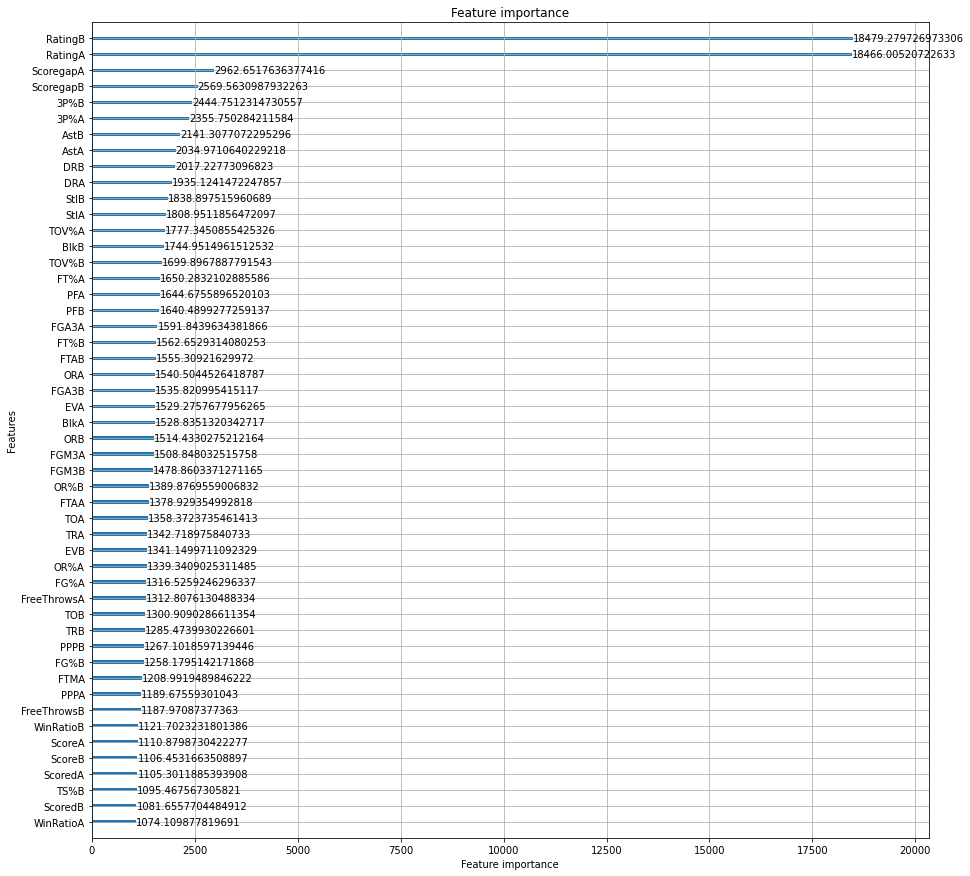

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
plt.show()

### V. Submission

In [ ]:
result = pd.read_csv("./2021NCAA.csv")
test["Predict"] = y_pred_test
pred = test[["TeamIdA","TeamIdB","Predict"]]

In [ ]:
total = result.merge(pred,left_on=["TeamIdA","TeamIdB"],right_on=["TeamIdA","TeamIdB"])
total

TeamIdA  TeamIdB  Result   Predict
0      1111     1313       0  0.588244
1      1179     1455       1  0.680744
2      1277     1417       0  0.214963
3      1140     1417       0  0.559887
4      1101     1417       0  0.326726
..      ...      ...     ...       ...
62     1160     1199       0  0.522944
63     1101     1400       1  0.140610
64     1163     1268       0  0.353653
65     1104     1233       1  0.940747
66     1104     1268       1  0.794028

[67 rows x 4 columns]

In [ ]:
score = log_loss(total["Result"],total["Predict"])
score

0.5749871751071136